In [19]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from scipy import signal
import math
from matplotlib.colors import Normalize

In [114]:
# load the sst and prcp data
workdir = '/docker/mnt/d/research/D2/cnn3'
sst_path = workdir + '/predictors/predictors_coarse_std_Apr_o.npy'
#prcp_path = workdir + '/predictant/continuous/pr_5x5_coarse_std_MJJASO_thailand.npy'
prcp_path = workdir + '/predictant/continuous/pr_1x1_std_MJJASO_thailand.npy'

In [115]:
sst = np.load(sst_path)
prcp = np.load(prcp_path)

In [116]:
print(sst.shape, prcp.shape)

(1, 42, 165, 24, 72) (42, 165, 20, 20)


In [117]:
def show_sst(image, img_extent):
    projection = ccrs.PlateCarree(central_longitude=180)

    fig = plt.figure()
    ax = plt.subplot(projection=projection)
    ax.coastlines()
    mat = ax.matshow(image,
                     origin='upper',
                     extent=img_extent,
                     transform=projection)
    plt.show()

In [118]:
import numpy.ma as ma

def mask(x):
    m = ma.masked_where(x>9999, x)
    z = ma.masked_where(m==0, m)
    f = ma.filled(z, np.nan)
    return f

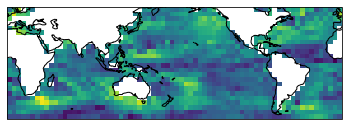

In [119]:
img_extent = (-180, 180, -60, 60)
sst_m0_y0 = sst[0, 0, 0, :, :]
sst_m0_y0 = mask(sst_m0_y0)
show_sst(sst_m0_y0, img_extent)

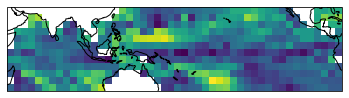

In [120]:
# space: - SST: 45E-75W, 30S-30N, PRCP: 95E-110E, 10N-20N
## 24 -> S60-N60, 72 -> 0E-360E
## lat[6:18], lon[9:36+21]
img_extent = (-135, 105, -30, 30)
ocean = sst_m0_y0[6:18, 9:57]
show_sst(ocean, img_extent)
nan_ind = np.where(np.isnan(ocean))

In [121]:
def show_prcp(image):
    projection =ccrs.PlateCarree(central_longitude=180)
    img_extent = (-90, -70, 5, 25) # location=(N5-25, #90-110)
    
    fig = plt.figure()
    ax = plt.subplot(projection=projection)
    ax.coastlines()
    mat = ax.matshow(image,
                     origin='upper',
                     extent=img_extent,
                     transform=projection)
    cbar = fig.colorbar(mat, 
                        extend='both',
                        spacing='proportional',
                        orientation='vertical')
    plt.show()

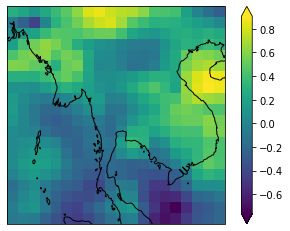

In [122]:
pr_m0_y0 =prcp[0,0,:,:]
show_prcp(pr_m0_y0)

In [123]:
def latlon_to_X(var):
    imt, jmt, tmt = var.shape
    X = np.zeros((imt*jmt, tmt))
    
    cc = 0
    for ii in range(0, imt):
        for jj in range(0, jmt):
            if np.isnan(var[ii, jj, 0]) == False:
                X[cc, :] = np.squeeze(var[ii, jj, :])
                cc = cc + 1
    X = np.squeeze(X[0:cc, :])
    return X

In [147]:
# creating sst and prcp matrix

tmp = sst[0, 1, -30:, 6:18, 9:57] # indian ocean and pacific ocean
tmp = tmp.transpose(1,2,0) # transpose time at last position
tmp = mask(tmp) # mask land area in sst data
print(tmp.shape)
X = latlon_to_X(tmp) # convert data (points, time)
print(X.shape)

tmp = prcp[0, -30:, :, :]
tmp = tmp.transpose(1,2,0)
tmp = mask(tmp)
print(tmp.shape)
Y = latlon_to_X(tmp)
print(Y.shape)

(12, 48, 30)
(470, 30)
(20, 20, 30)
(400, 30)


# 転置が必要かどうかに関してはnotion/SVD理論/展開係数を参照

In [180]:
# creating covariance matrix
N = X.shape[1]
C_XY = X@Y.T/N

P, S, QT = np.linalg.svd(C_XY, full_matrices=False)

Q = QT.T

print(C_XY.shape)
print(P.shape, Q.shape)

(470, 400)
(470, 400) (400, 400)


In [200]:
# prediction
tmp = sst[0, 2, -30:, 6:18, 9:57] # indian ocean and pacific ocean
tmp = mask(tmp) # mask land area in sst data
tmp = tmp.transpose(1,2,0) # transpose time at last position
print(tmp.shape)
X = latlon_to_X(tmp) # convert data (points, time)
print(X.shape)

sst_input = X[:, -1] # chose year=2014
print(sst_input.shape)

(12, 48, 30)
(470, 30)
(470,)


In [201]:
# calculate time expansion coefficient A
A = P.T@sst_input
print(A.shape) # 400個モード毎の展開係数であると認識できる(時刻は1つしかないから1次元)

(400,)


In [202]:
print(Q.T[0].shape)
print(A[0])
mode_i = Q.T[0]*A[0]
print(mode_i.shape)

(400,)
21.32012794295464
(400,)


In [203]:
# calculate prcp
grids = 20*20
prcp_output = np.zeros(grids)
for i in range(grids):
    mode_i = Q.T[i]*A[i]
    prcp_output += mode_i
print(prcp_output.shape)

(400,)


In [204]:
def X_to_latlon(X):
    imt, jmt = 20, 20
    
    SVDs = np.zeros((imt, jmt))
    
    cc = 0
    for ii in range(0, imt):
        for jj in range(0, jmt):
            SVDs[ii, jj] = X[cc]
            cc += 1
    
    return SVDs

In [205]:
prcp_latlon = X_to_latlon(prcp_output)

In [206]:
print(prcp_latlon.shape)

(20, 20)


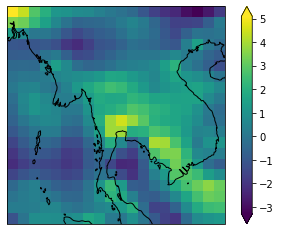

In [207]:
show_prcp(prcp_latlon)

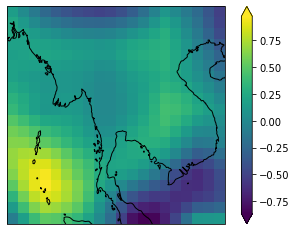

In [208]:
prcp_label = prcp[2, -1, :, :] # validation label
show_prcp(prcp_label)